In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import torch
from torch import nn
from models.imavae import IMAVAE
from scipy.stats import zscore,norm
import matplotlib as mpl
from PIL import Image
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# To make this notebook's output stable across runs
np.random.seed(2020)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. Simulate Dataset

* Follow **simulation 1** in Nath, Tanmay, et al. "A machine learning based approach towards high-dimensional mediation analysis." NeuroImage 268 (2023): 119843.
* We simulate a situation in which the latent mediator scores $z$ are a complex, nonlinear function of an observed set of mediator variables.
* To accomplish this, in our simulations, we embedded the mediator in an image whose pixels represent the values of handwritten digits.

In [2]:
#define a function to extract image
from sklearn.datasets import fetch_openml
mnist_dataset = fetch_openml('mnist_784')

In [3]:
def concat_images(imga, imgb):
    """
    Combines two color image ndarrays side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    total_width = wa+wb
    new_img = np.zeros(shape=(max_height, total_width))
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    return new_img

def extract_image(num,mnist_dataset,new_shape):
    """
    Used for data simulation.Returns the image
    num: string. The string of number and a digit is replaced with an actual image.
    """
    target = mnist_dataset.target
    mnist_image = mnist_dataset.data
    img_shape = (int(np.sqrt(mnist_image.shape[-1])) , int(np.sqrt(mnist_image.shape[-1])))
    image= []
    for j in range(len(num)):
        indexes = np.where(target==num[j])[0]
        # Randomly sample an index from the selected indexes
        random_index = np.random.choice(indexes)
        raw_img = mnist_image.iloc[random_index]
        raw_img = raw_img.values.reshape(img_shape)
        new_img = Image.fromarray(raw_img)
        img = new_img.resize(size=(new_shape[0],new_shape[1]))
        img = np.asarray(img)
        if j==0:
            output = img
        else:
            output = concat_images(output, img)
    image.append(output)
    return np.concatenate(image)

In [4]:
#number of obs
N = 1000
#pre-defined parameters
p = 0.5
alpha,alpha0,beta0,beta,gamma = 0.2,-0.1,6,4,5
new_shape = [28,28]
#T = np.random.normal(0,1,N)
T = np.random.binomial(n=1, p=[p for _ in range(N)])
e0 = np.random.normal(0,1,N)
#simulate low-dimensional mediator m
m = alpha0 + alpha*T + e0

#simulate high-dimensional observed variables X
cdfm = norm.cdf(m)
##Simulate images
X = []
floating_pt = [str(i)[2:6].zfill(4) for i in cdfm] # makes sure that there are 4 digits after decimal point
for num in floating_pt:
    image = extract_image(num,mnist_dataset,new_shape)
    X.append(image)
X = np.array(X) #multi-dimensional
e2 = np.random.normal(0,1,N)
Y = beta0 + gamma*T + beta*m + e2

In [8]:
#reshape X,Y,T
T = T.reshape(-1,1)
Y = Y.reshape(-1,1)

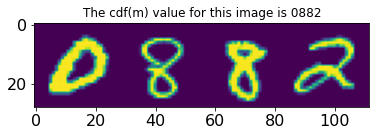

In [9]:
import matplotlib.pyplot as plt
idx=0
x,y = new_shape[0],new_shape[1]*4
plt.imshow(X[idx].reshape(x,y))
plt.title("The cdf(m) value for this image is %s"%str(cdfm[idx])[2:6])
plt.show()

The average causal mediation, direct, and total effect are defined as:
\begin{align}
\bar{\delta}(t) &= \mathbb{E}\left[ Y_i(t, M_i(1)) - Y_i(t, M_i(0)) \right] \\
\bar{\zeta}(t) &= \mathbb{E}\left[ Y_i(1, M_i(t)) - Y_i(0, M_i(t)) \right] \\
\bar{\tau} &= \mathbb{E}\left[ Y_i(1, M_i(1)) - Y_i(0, M_i(0)) \right]
\end{align}

In [10]:
m_0 = alpha0 + e0
m_1 = alpha0 + alpha*np.ones(N) + e0
Y0_M0 = beta0 + (gamma * np.zeros(N) + m_0 * beta + e2).reshape(-1,1)
Y0_M1 = beta0 + (gamma * np.zeros(N) + m_1 * beta + e2).reshape(-1,1)
Y1_M0 = beta0 +(gamma * np.ones(N) + m_0 * beta + e2).reshape(-1,1)
Y1_M1 = beta0 + (gamma * np.ones(N) + m_1 * beta + e2).reshape(-1,1)
acme_c = (Y0_M1 - Y0_M0).mean()
acme_t = (Y1_M1 - Y1_M0).mean()
ade_c = (Y1_M0 - Y0_M0).mean()
ade_t = (Y1_M1 - Y0_M1).mean()
ate = (Y1_M1 - Y0_M0).mean()
print("True ACME (control) = {:.4f}".format(acme_c))
print("True ACME (treatment) = {:.4f}".format(acme_t))
print("True ADE (control) = {:.4f}".format(ade_c))
print("True ADE (treatment) = {:.4f}".format(ade_t))
print("True ATE = {:.4f}".format(ate))

True ACME (control) = 0.8000
True ACME (treatment) = 0.8000
True ADE (control) = 5.0000
True ADE (treatment) = 5.0000
True ATE = 5.8000


In [11]:
X = X.reshape(X.shape[0],X.shape[1]*X.shape[2])
X = X/np.max(X)

# 2. Fit IMAVAE model and evaluate mediation effect

In [ ]:
imavae = IMAVAE(n_components=256, n_sup_networks=256, n_hidden_layers=2, hidden_dim=512, 
               optim_name='Adam',recon_weight=0.1, elbo_weight=0.1,sup_weight=1.)
_ = imavae.fit(
    X, T, Y, X_val=X, aux_val=T, y_val=Y, 
    lr=1e-5, n_epochs=500, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(T, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(T, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(T, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(T, treatment=True)
ate_mean, ate_std = imavae.ate_score(T)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))
print("-------------------------------------")
print("ACME err (control) = {:.4f} +/- {:.4f}".format(abs(acme_c - acme_c_mean), acme_c_std))
print("ACME err (treatment) = {:.4f} +/- {:.4f}".format(abs(acme_t - acme_t_mean), acme_t_std))
print("ADE err (control) = {:.4f} +/- {:.4f}".format(abs(ade_c - ade_c_mean), ade_c_std))
print("ADE err (treatment) = {:.4f} +/- {:.4f}".format(abs(ade_t - ade_t_mean), ade_t_std))
print("ATE err = {:.4f} +/- {:.4f}".format(abs(ate - ate_mean), ate_std))

### 2.1 Does the latent feature learned by IMAVAE recover the true mediator?

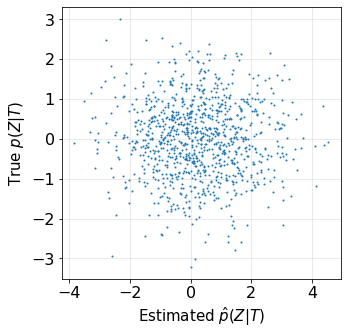

In [48]:
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1).to(device), torch.ones(N, 1).to(device)
    z_m0 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
    z_m1 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
    # Estimated z_m for factual outcomes
    z_m = torch.stack([z_m0[i,:] if T[i,0] == 0 else z_m1[i,:] for i in range(N)]).cpu().detach().numpy()

plt.figure(figsize=(5, 5))
plt.scatter(z_m,m,s=1)
plt.xlabel('Estimated $\hat{p}(Z|T)$',fontsize=15)
plt.ylabel('True $p(Z|T)$',fontsize=15)
plt.grid(color='gray', linestyle='solid',alpha=0.2)


#axs[1].set_title("Estimated $\hat{p}(Z|T)$", size=20)